In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from sklearn.preprocessing import PolynomialFeatures

from scipy.stats import randint, uniform

# Dataset

In [3]:
df = pd.read_csv("heart_failure_clinical_records.csv")
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,55.0,0,748,0,45,0,263358.03,1.3,137,1,1,88,0
1,65.0,0,56,0,25,0,305000.00,5.0,130,1,0,207,0
2,45.0,0,582,1,38,0,319000.00,0.9,140,0,0,244,0
3,60.0,1,754,1,40,1,328000.00,1.2,126,1,0,90,0
4,95.0,1,582,0,30,0,461000.00,2.0,132,1,0,50,1


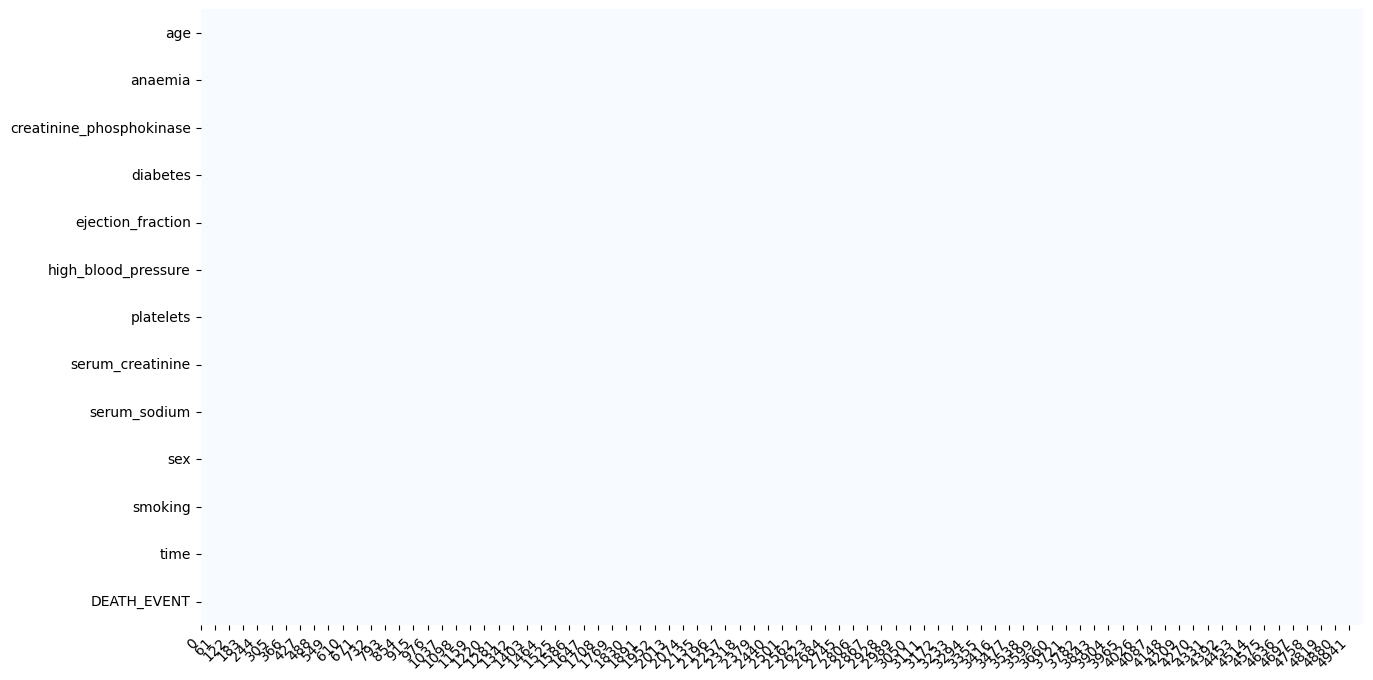

In [4]:
plot_missing_value(df)

# Datasplitting

In [5]:
X = df.drop(columns="DEATH_EVENT")
y = df.DEATH_EVENT

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4000, 12), (1000, 12), (4000,), (1000,))

# Training 

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

from sklearn.metrics import make_scorer, f1_score

In [10]:
X.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,55.0,0,748,0,45,0,263358.03,1.3,137,1,1,88
1,65.0,0,56,0,25,0,305000.00,5.0,130,1,0,207
2,45.0,0,582,1,38,0,319000.00,0.9,140,0,0,244
3,60.0,1,754,1,40,1,328000.00,1.2,126,1,0,90
4,95.0,1,582,0,30,0,461000.00,2.0,132,1,0,50


In [9]:
X.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time'],
      dtype='object')

In [12]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['age',  'creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine', 'serum_sodium','time']),
    ('categoric', cat_pipe(encoder="onehot"),['anaemia','diabetes','high_blood_pressure','sex','smoking'])
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

paramater = {'algo__n_estimators': [100, 150, 200],
             'algo__max_depth': [20, 50, 80],
             'algo__max_features': [0.3, 0.6, 0.8],
             'algo__min_samples_leaf': [1, 5, 10]}


model = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'algo__max_depth': 71, 'algo__max_features': 0.27164969851209264, 'algo__min_samples_leaf': 3, 'algo__n_estimators': 193}
0.99525 0.9907510610786131 0.991


tidak melakukan apapun tapi score sudah sangat baik

# Feature Importance

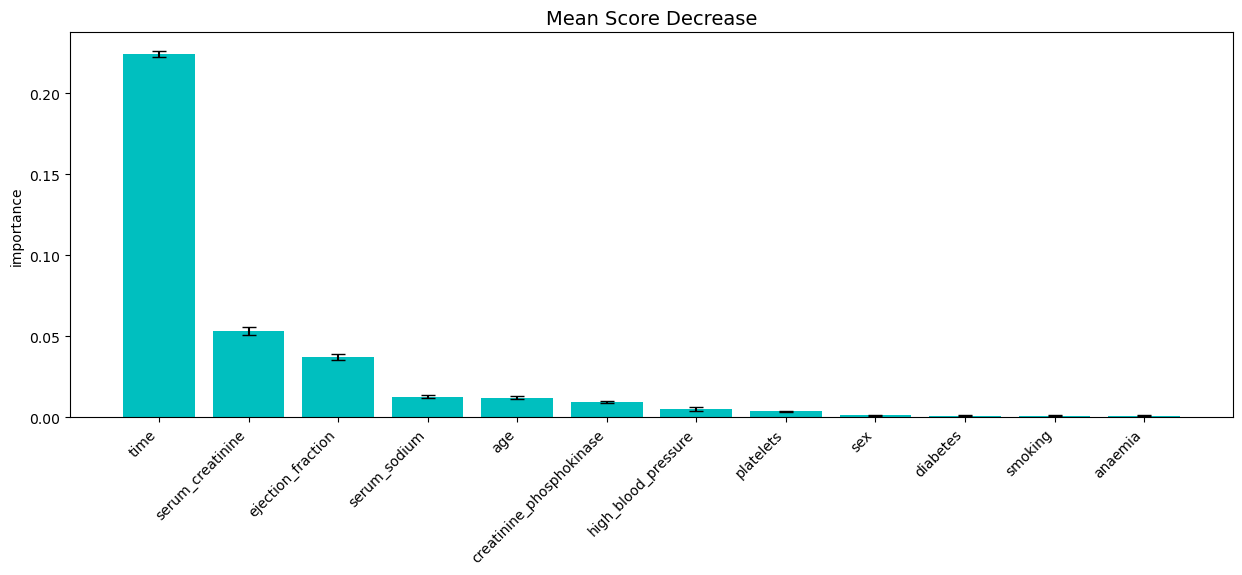

In [13]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=X_train.shape[1])

In [14]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['creatinine_phosphokinase','ejection_fraction','serum_creatinine', 'serum_sodium','time','age']),
    ('categoric', cat_pipe(encoder="onehot"),['high_blood_pressure'])
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1))
])

paramater = {'algo__n_estimators': [100, 150, 200],
             'algo__max_depth': [20, 50, 80],
             'algo__max_features': [0.3, 0.6, 0.8],
             'algo__min_samples_leaf': [1, 5, 10]}


model = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'algo__max_depth': 54, 'algo__max_features': 0.9879278053654715, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 189}
0.999 0.992000811297277 0.993


# Coba menggunakan Poly di feature numeric 

In [18]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), ['creatinine_phosphokinase','ejection_fraction','serum_creatinine', 'serum_sodium','time','age']),
    ('categoric', cat_pipe(encoder="onehot"),['high_blood_pressure'])
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1))
])

paramater = {'algo__n_estimators': [100, 150, 200],
             'algo__max_depth': [20, 50, 80],
             'algo__max_features': [0.3, 0.6, 0.8],
             'algo__min_samples_leaf': [1, 5, 10]}


model = RandomizedSearchCV(pipeline, rsp.rf_poly_params, cv=3, n_iter=50, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__max_depth': 32, 'algo__max_features': 0.5309874766116955, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 197, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': False}
0.999 0.9927509988441638 0.992
